# Import các thư viện cần thiết


In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.vgg import VGG, make_layers
from torch.hub import load_state_dict_from_url

# Kiểm tra thiết bị (device)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


# Load and transform data


In [3]:
flip_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_fc = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transformed_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=flip_train
)

original_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transform_fc    
)

training_data = torch.utils.data.ConcatDataset([transformed_data,original_data])

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform_fc
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle= True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Một số samples trong CIFAR-10

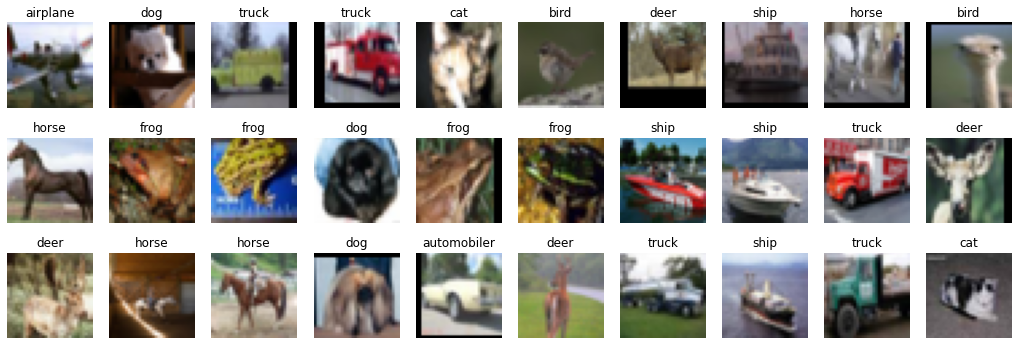

In [5]:
labels_map = {
    0: "airplane",
    1: "automobiler",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
figure = plt.figure(figsize=(18, 6))
cols, rows = 10, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")  

    inp = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
plt.show()

#Model

In [6]:
class vgg(VGG):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, num_classes),            
        )
        if init_weights:
            self._initialize_weights()

In [7]:
cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [8]:
# VGG16
vgg16 = vgg(make_layers(cfgs['D'], True), num_classes=10).to(device)


In [9]:
# ResNet50
#resnet = ResNet(Bottleneck, [3, 4, 6, 3], num_classes=10).to(device)
# ResNet18
resnet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10).to(device)
# ResNet101
#resnet = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=10).to(device)

# Train loop

In [10]:
res_loss = []
vgg_loss = []
loss_glb = []

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_glb.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")    
        

# Test loop

In [12]:
test_glb = []
test_vgg = []
test_resnet = []

In [13]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():       #dừng tính gradient khi dự đoán trên test
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches   
    test_glb.append(test_loss) 
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train model
* `scheduler` giảm giá trị của learning rate sau mỗi epoch sử dụng kỹ thuật [`CosineAnnealingLR`](https://wiki.hasty.ai/scheduler/cosineannealinglr)
* Xem thêm về [learning rate decay](https://www.youtube.com/watch?v=QzulmoOg2JE)

In [14]:
def train(model,epochs, learning_rate):
  loss_fn = nn.CrossEntropyLoss()
  # Observe that all parameters are being optimized
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  # Learining rate decay
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
  for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    scheduler.step()
  print("Done!")

In [15]:
lr = 0.001
epochs = 10

## ResNet

In [16]:
res_st = time.perf_counter()
train(resnet,epochs,lr)
res_end = time.perf_counter()
res_loss = loss_glb
test_resnet = test_glb
loss_glb = []
test_glb = []

Epoch 1
-------------------------------
loss: 2.477809  [    0/100000]
loss: 1.615785  [12800/100000]
loss: 1.439806  [25600/100000]
loss: 1.381613  [38400/100000]
loss: 1.304012  [51200/100000]
loss: 1.112247  [64000/100000]
loss: 1.223573  [76800/100000]
loss: 1.251960  [89600/100000]
Test Error: 
 Accuracy: 65.3%, Avg loss: 0.997067 

Epoch 2
-------------------------------
loss: 0.908210  [    0/100000]
loss: 1.029781  [12800/100000]
loss: 0.993274  [25600/100000]
loss: 0.933982  [38400/100000]
loss: 0.835996  [51200/100000]
loss: 0.966087  [64000/100000]
loss: 0.837261  [76800/100000]
loss: 0.703266  [89600/100000]
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.802639 

Epoch 3
-------------------------------
loss: 0.697570  [    0/100000]
loss: 0.692165  [12800/100000]
loss: 0.773779  [25600/100000]
loss: 0.653866  [38400/100000]
loss: 0.754389  [51200/100000]
loss: 0.703500  [64000/100000]
loss: 0.779190  [76800/100000]
loss: 0.664713  [89600/100000]
Test Error: 
 Accuracy: 75.0%, A

## VGG

In [17]:
vgg_st = time.perf_counter()
train(vgg16,epochs,lr)
vgg_end = time.perf_counter()
vgg_loss = loss_glb
test_vgg = test_glb

Epoch 1
-------------------------------
loss: 2.961395  [    0/100000]
loss: 2.509958  [12800/100000]
loss: 2.360110  [25600/100000]
loss: 2.650790  [38400/100000]
loss: 2.116362  [51200/100000]
loss: 1.961834  [64000/100000]
loss: 2.058291  [76800/100000]
loss: 1.929628  [89600/100000]
Test Error: 
 Accuracy: 27.5%, Avg loss: 1.915890 

Epoch 2
-------------------------------
loss: 1.944496  [    0/100000]
loss: 1.855267  [12800/100000]
loss: 1.764689  [25600/100000]
loss: 1.729977  [38400/100000]
loss: 1.608509  [51200/100000]
loss: 1.917069  [64000/100000]
loss: 1.506200  [76800/100000]
loss: 1.664757  [89600/100000]
Test Error: 
 Accuracy: 43.7%, Avg loss: 1.474412 

Epoch 3
-------------------------------
loss: 1.674672  [    0/100000]
loss: 1.555081  [12800/100000]
loss: 1.522297  [25600/100000]
loss: 1.435307  [38400/100000]
loss: 1.198421  [51200/100000]
loss: 1.309603  [64000/100000]
loss: 1.391056  [76800/100000]
loss: 0.978799  [89600/100000]
Test Error: 
 Accuracy: 61.1%, A

# ResNet18 vs. VGG16

### Elapsed time 

In [18]:
import datetime

In [19]:
print('VGG16 : ', datetime.timedelta(seconds=(vgg_end-vgg_st)))
print('ResNet18 : ',datetime.timedelta(seconds=(res_end-res_st)))

VGG16 :  0:25:38.889100
ResNet18 :  0:09:31.513061


### Train and test error

In [20]:
def func(x):
  return x/8
def defunc(x):
  return x*8

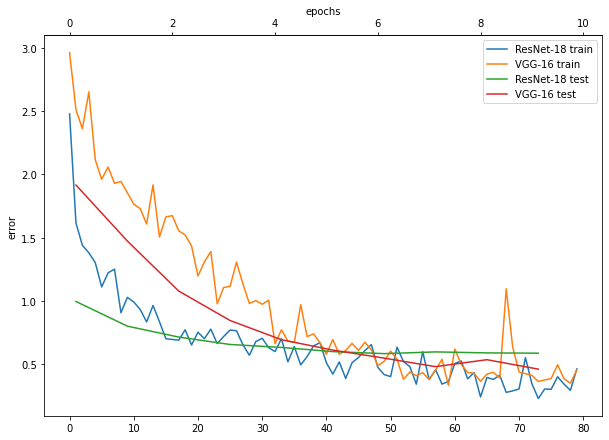

In [21]:
x = range(len(res_loss))
n = len(x) 
m = int(n/epochs)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(x, res_loss, label='ResNet-18 train') 
ax.plot(x, vgg_loss, label='VGG-16 train')  
ax.set_ylabel('error')  # Add a y-label to the axes.
ax.secondary_xaxis('top', functions=(func,defunc)).set_xlabel('epochs')
ax.plot(range(1,n,m), test_resnet, label='ResNet-18 test')
ax.plot(range(1,n,m), test_vgg, label='VGG-16 test')
ax.legend();  # Add a legend.

# ResNet34 vs. VGG19

In [22]:
vgg19 = vgg(make_layers(cfgs['E'], True), num_classes=10).to(device)
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=10).to(device)

In [23]:
loss_glb = []
test_glb = []

In [24]:
res34_st = time.perf_counter()
train(resnet34,epochs,lr)
res34_end = time.perf_counter()
res34_loss = loss_glb
test_resnet34 = test_glb
loss_glb = []
test_glb = []

Epoch 1
-------------------------------
loss: 2.894177  [    0/100000]
loss: 1.815093  [12800/100000]
loss: 1.425258  [25600/100000]
loss: 1.396559  [38400/100000]
loss: 1.297248  [51200/100000]
loss: 1.163554  [64000/100000]
loss: 1.130147  [76800/100000]
loss: 1.046426  [89600/100000]
Test Error: 
 Accuracy: 64.5%, Avg loss: 0.987839 

Epoch 2
-------------------------------
loss: 1.028580  [    0/100000]
loss: 0.908655  [12800/100000]
loss: 0.966710  [25600/100000]
loss: 0.852644  [38400/100000]
loss: 0.933522  [51200/100000]
loss: 0.950169  [64000/100000]
loss: 0.936258  [76800/100000]
loss: 0.975459  [89600/100000]
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.821909 

Epoch 3
-------------------------------
loss: 0.650636  [    0/100000]
loss: 0.829220  [12800/100000]
loss: 0.787791  [25600/100000]
loss: 0.917220  [38400/100000]
loss: 0.793912  [51200/100000]
loss: 0.816397  [64000/100000]
loss: 0.806326  [76800/100000]
loss: 0.623335  [89600/100000]
Test Error: 
 Accuracy: 75.7%, A

In [25]:
vgg19_st = time.perf_counter()
train(vgg19,epochs,lr)
vgg19_end = time.perf_counter()
vgg19_loss = loss_glb
test_vgg19 = test_glb

Epoch 1
-------------------------------
loss: 4.340145  [    0/100000]
loss: 3.134639  [12800/100000]
loss: 2.287836  [25600/100000]
loss: 2.337845  [38400/100000]
loss: 2.556579  [51200/100000]
loss: 2.087960  [64000/100000]
loss: 2.025067  [76800/100000]
loss: 2.016965  [89600/100000]
Test Error: 
 Accuracy: 22.0%, Avg loss: 2.479622 

Epoch 2
-------------------------------
loss: 1.889811  [    0/100000]
loss: 2.814061  [12800/100000]
loss: 2.446954  [25600/100000]
loss: 1.916614  [38400/100000]
loss: 2.192860  [51200/100000]
loss: 2.270891  [64000/100000]
loss: 1.965379  [76800/100000]
loss: 2.067340  [89600/100000]
Test Error: 
 Accuracy: 28.8%, Avg loss: 1.934508 

Epoch 3
-------------------------------
loss: 1.846205  [    0/100000]
loss: 1.954740  [12800/100000]
loss: 1.656175  [25600/100000]
loss: 1.765901  [38400/100000]
loss: 1.879997  [51200/100000]
loss: 1.851347  [64000/100000]
loss: 1.665973  [76800/100000]
loss: 1.691949  [89600/100000]
Test Error: 
 Accuracy: 37.2%, A

### Elapsed time

In [26]:
print('VGG19 : ', datetime.timedelta(seconds=(vgg19_end-vgg19_st)))
print('ResNet34 : ',datetime.timedelta(seconds=(res34_end-res34_st)))

VGG19 :  0:29:13.039893
ResNet34 :  0:17:50.157499


### Train and test error

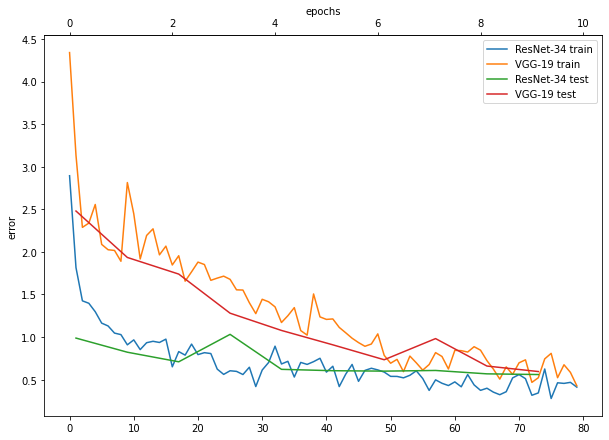

In [27]:
x = range(len(res34_loss))
n = len(x) 
m = int(n/epochs)
fig0, ax0 = plt.subplots(figsize=(10,7))
ax0.plot(x, res34_loss, label='ResNet-34 train') 
ax0.plot(x, vgg19_loss, label='VGG-19 train')  
ax0.set_ylabel('error')
ax0.secondary_xaxis('top', functions=(func,defunc)).set_xlabel('epochs')
ax0.plot(range(1,n,m), test_resnet34, label='ResNet-34 test')
ax0.plot(range(1,n,m), test_vgg19, label='VGG-19 test')
ax0.legend()

### VGG19 vs. VGG16

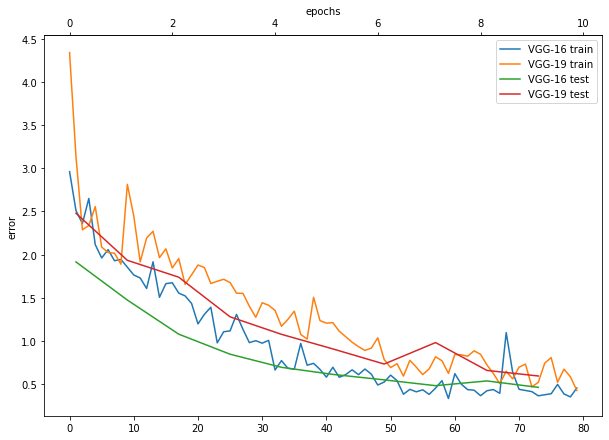

In [28]:
fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(x, vgg_loss, label='VGG-16 train') 
ax1.plot(x, vgg19_loss, label='VGG-19 train')  
ax1.set_ylabel('error')
ax1.secondary_xaxis('top', functions=(func,defunc)).set_xlabel('epochs')
ax1.plot(range(1,n,m), test_vgg, label='VGG-16 test')
ax1.plot(range(1,n,m), test_vgg19, label='VGG-19 test')
ax1.legend()

### ResNet18 vs. ResNet34

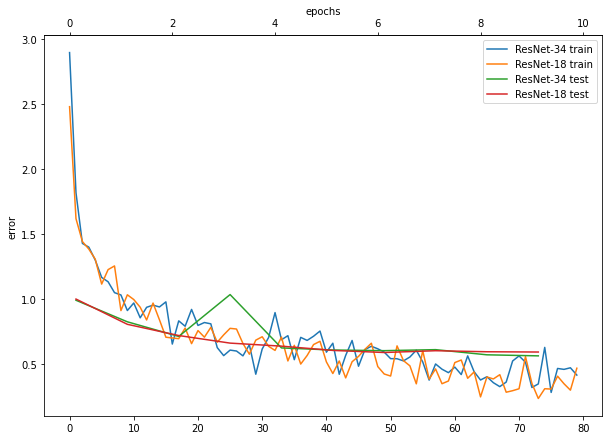

In [29]:
fig2, ax2 = plt.subplots(figsize=(10,7))
ax2.plot(x, res34_loss, label='ResNet-34 train') 
ax2.plot(x, res_loss, label='ResNet-18 train')  
ax2.set_ylabel('error')
ax2.secondary_xaxis('top', functions=(func,defunc)).set_xlabel('epochs')
ax2.plot(range(1,n,m), test_resnet34, label='ResNet-34 test')
ax2.plot(range(1,n,m), test_resnet, label='ResNet-18 test')
ax2.legend()